In [2]:

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


import os
import re


import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora 
from gensim.models.ldamulticore import LdaMulticore
#from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
import pyLDAvis.gensim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from nltk.stem import SnowballStemmer


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier, SGDRegressor 


from sklearn.ensemble import RandomForestClassifier


from sklearn.neighbors import NearestNeighbors


from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder


import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Conv1D, MaxPooling1D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.preprocessing import sequence #one_hot, hashing_trick
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Counter, Iterable
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from

In [5]:
reviews_df = pd.read_csv('review.csv', engine='python', error_bad_lines=False)
business_df = pd.read_csv('business.csv')

/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6.0,1.0,0.0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0.0,0.0,0.0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3.0,0.0,0.0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0.0,0.0,0.0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7.0,0.0,0.0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [7]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
business_df.head()


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.GoodForMeal,attributes.BusinessParking,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.Ambience,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,hours.Monday,hours.Tuesday,hours.Wednesday,hours.Thursday,hours.Friday,hours.Saturday,hours.Sunday,attributes.BusinessAcceptsCreditCards,attributes,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.Music,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.BestNights,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.HairSpecializesIn,attributes.Corkage,attributes.BYOB,attributes.DietaryRestrictions,attributes.Open24Hours,attributes.RestaurantsCounterService
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,"Golf, Active Life",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"Specialty Food, Restaurants, Dim Sum, Imported...",NaN,True,True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",True,u'loud',True,True,2,False,False,"{'romantic': False, 'intimate': False, 'classy...",False,u'no',u'full_bar',u'casual',True,False,9:0-0:0,9:0-0:0,9:0-0:0,9:0-0:0,9:0-1:0,9:0-1:0,9:0-0:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",NaN,True,True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",False,u'average',True,True,2,False,True,"{'romantic': False, 'intimate': False, 'touris...",True,u'no',u'beer_and_wine','casual',True,False,17:30-21:30,NaN,17:30-21:30,17:30-21:30,17:30-22:0,17:30-22:0,17:30-21:0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,"Insurance, Financial Services",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8:0-17:0,8:0-17:0,8:0-17:0,8:0-17:0,8:0-17:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"Plumbing, Shopping, Local Services, Home Servi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,True,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(reviews_df.shape)

(6685902, 9)


In [9]:
reviews_df = reviews_df.drop(columns = {'review_id', 'date', 'useful', 'funny', 'cool'})
business_df = business_df.drop(columns = {'name', 'address', 'postal_code', 'latitude', 'longitude', 'is_open', 'categories', 'city', 'state', 'review_count','hours','attributes.GoodForKids', 'attributes.RestaurantsReservations', 'attributes.GoodForMeal', 'attributes.BusinessParking', 'attributes.Caters', 'attributes.NoiseLevel', 'attributes.RestaurantsTableService', 'attributes.RestaurantsTakeOut', 'attributes.RestaurantsPriceRange2', 'attributes.OutdoorSeating','attributes.BikeParking', 'attributes.Ambience', 'attributes.HasTV', 'attributes.WiFi', 'attributes.Alcohol', 'attributes.RestaurantsAttire', 'attributes.RestaurantsGoodForGroups', 'attributes.RestaurantsDelivery', 'hours.Monday', 'hours.Tuesday', 'hours.Wednesday', 'hours.Thursday', 'hours.Friday', 'hours.Saturday', 'hours.Sunday','attributes.BusinessAcceptsCreditCards','attributes','attributes.BusinessAcceptsBitcoin','attributes.ByAppointmentOnly','attributes.AcceptsInsurance','attributes.Music','attributes.GoodForDancing','attributes.CoatCheck','attributes.HappyHour','attributes.BestNights','attributes.WheelchairAccessible','attributes.DogsAllowed','attributes.BYOBCorkage','attributes.DriveThru','attributes.Smoking','attributes.AgesAllowed','attributes.HairSpecializesIn','attributes.Corkage','attributes.BYOB','attributes.DietaryRestrictions','attributes.Open24Hours','attributes.RestaurantsCounterService'})
business_df = business_df.rename(columns={'stars' : 'rating'})

In [10]:
print(reviews_df.shape)
reviews_df.head()

(6685902, 4)


,user_id,business_id,stars,text
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,Total bill for this horrible service? Over $8G...
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,I *adore* Travis at the Hard Rock's new Kelly ...
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,I have to say that this office really has it t...
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,Today was my second out of three sessions I ha...


## Merging the DataFrames

In [11]:
''' Merging the DataFrames '''
reviews_df = pd.merge(reviews_df, business_df, how='inner')

In [12]:
print(reviews_df.shape)
reviews_df.head()

(6685900, 5)


,user_id,business_id,stars,text,rating
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,Total bill for this horrible service? Over $8G...,2.5
1,RBXSJA372ilErzNwz0jXvQ,ujmEBvifdJM6h6RLv4wQIg,4.0,My family has used this ER four times in the p...,2.5
2,x3brMMbJrAW9PwW5A6YL5w,ujmEBvifdJM6h6RLv4wQIg,1.0,I have never been more disappointed by the car...,2.5
3,Skzdl0sWhW88525a1vr59g,ujmEBvifdJM6h6RLv4wQIg,1.0,"Went in for a broken finger, was asked if I wa...",2.5
4,3Y25VDfnQVcuc33T-U3Z6A,ujmEBvifdJM6h6RLv4wQIg,5.0,My mother was at Mountain View for nearly two ...,2.5


In [13]:
reviews_df.isnull().sum()

user_id        0
business_id    0
stars          0
text           2
rating         0
dtype: int64

In [14]:
reviews_df.isnull().sum()

user_id        0
business_id    0
stars          0
text           2
rating         0
dtype: int64

In [15]:
reviews_df[reviews_df.isnull().any(axis=1)]

,user_id,business_id,stars,text,rating
3947686,pUKAjAaSMkxiJ1WCIFSsBQ,I7XWtKL1oHohZCtCCyQIog,1.0,NaN,2.0
6103360,v3DIq18Z30KNwyUvBXtXEA,oXoVJ0xKv82cBo9U6oEjlQ,3.0,NaN,3.5


In [16]:
reviews_df =reviews_df.drop([3947686, 6103360])

In [17]:
reviews_df.isnull().sum()

user_id        0
business_id    0
stars          0
text           0
rating         0
dtype: int64

## Mask

In [18]:
mask = (reviews_df['text'].str.contains('tacos'))
reviews_df = reviews_df[mask]
restaurant_df = reviews_df


## Split Data

In [19]:
# reviews_df, X_test = train_test_split(reviews_df, train_size = .92, random_state=69)

## Tokenize Function

In [20]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import spacy

nlp = spacy.load('en_core_web_lg')

STOPWORDS = set(STOPWORDS).union(set(['in', ' ', '', '\\n', 'strain', 'an', '$', 'got', 'as', 'the', 'it', 'place', '+', 'service', 'time']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [21]:
reviews_df['token'] = restaurant_df['text'].apply(tokenize)
reviews_df['token'].head()

4217    [think, friends, going, hate, rating, true, tr...
4226    [love, unique, culinary, concepts, encountered...
4273    [fan, years, coming, food, tasty, quick, hole,...
4311    [excellent, food, pretty, tasty, seen, coming,...
4643    [want, great, greasy, chex, mex, taj, mahal, j...
Name: token, dtype: object

In [22]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [23]:
wc = count(reviews_df['token'])

In [24]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
79,tacos,127122,200986,1.0,0.028768,0.028768,0.999143
38,food,65568,108103,2.0,0.015473,0.044241,0.515346
82,good,60243,100195,3.0,0.014341,0.058582,0.473493
163,great,46960,67749,4.0,0.009697,0.068279,0.369092
332,taco,32346,56878,5.0,0.008141,0.076420,0.254230


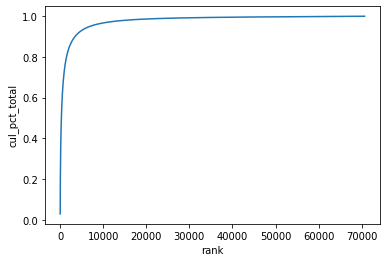

In [25]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [26]:
wc[wc['rank'] <= 20]['cul_pct_total'].max()

0.14984600401972592

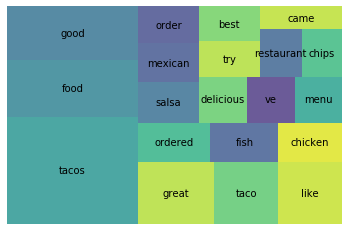

In [27]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words= 'english')
sparse = tfidf.fit_transform(reviews_df['text'])

In [29]:
reviews_df_vector = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())
reviews_df_vector.head()

,00,000,00032766,000th,001,0013,002,003,0033,00400000019838,007,00a,00am,00hrs,00ish,00p,00pm,00s,01,01100,0128,015,01pm,02,0200,0245,0246581,02am,02pm,03,0300,0345,0399,03july,03pm,04,0400,041,0430,05,0507,05am,05pm,06,0600,065,06july,06pm,07,0700,0700h,0700p,0716,0763,08,09,09u8,0_o,0h,0huv,0iz2t2ayk9vra1rhiwh__w,0l6cko_sj9iqvsgfcvbpgw,0lace,0n,0out,0started,0tax,10,100,1000,10000,100000,1000000,10000x,1000s,1000x,1002,100deg,100f,100ft,100ish,100lbs,100m,100ml,100mph,100plus,100pts,100s,100th,100x,100xs,101,1011,102,1020,10220923,103,1030,1030am,1030pm,1032,1035am,104,1040,1040pm,1045,105,1050,1050am,105deg,105f,105ième,105th,106,107,107th,108,109,10a,10am,10bucks,10c,10cehfj,10cent,10cents,10deeac,10dll,10f,10ft,10h,10hr,10ish,10k,10lb,10min,10mins,10minute,10minutes,10mnts,10ounce,10oz,10p,10pcs,10pieces,10pm,10pmish,10ppl,10s,10sec,10tacos,10th,10thtime,10times,10x,10x10,10x3,10xs,10years,10yr,10yrs,10人がけ程のカウンターがあるだけなので,11,110,1100,1101,1106,111,1115,1118,112,1125,11276,113,1130,1130a,1130am,1130ish,1130p,1130pm,114,1140,1143,1145,1145a,1145ish,1145pm,115,1150,115dbs,115f,116,117,117th,118,11868,119,1195,11a,11am,11h45,11in,11ish,11lbs,11m,11ncfoc,11oz,11p,11pm,11th,11x13,11yr,11yrs,12,120,1200,1202,1204,1205,120lb,120min,120mins,121,1210,1215,122,123,1230,1230am,1230pm,124,1240pm,1244981,1245,125,1250,1257,126,127,128,128877,128oz,129,129298443760458,129389481,12a,12am,12ft,12h,12hours,12hr,...,zilch,zillion,zillions,zimbabwe,zimmern,zin,zinburger,zinc,zinfandel,zing,zingara,zinged,zinger,zingers,zingy,zink,zins,zion,ziosk,zip,zipline,ziploc,ziplock,zipp,zipparita,zipparitas,zipped,zipper,zippier,zippiest,zipping,zippity,zippo,zipps,zippy,zippys,zips,zit,ziti,ziuhuen,zlantro,zo,zobacos,zobe,zoc,zocalo,zocalos,zocolo,zod,zoe,zoey,zoinks,zomato,zombie,zombies,zomg,zona,zone,zoned,zones,zoney,zongzi,zoni,zonies,zoning,zonked,zonkey,zoo,zoodle,zoodles,zooey,zooks,zoolander,zoom,zoomed,zooming,zooms,zoot,zopapan,zope,zopes,zornes,zorro,zotique,zounds,zoup,zowie,zoë,zsome,zteca,ztejas,ztrip,zu,zubrowka,zuc,zucc,zucchini,zucchinigetti,zucchinis,zucchni,zuccini,zuccinini,zuchini,zuchinmi,zuchinni,zucs,zucuni,zuke,zukes,zuko,zuma,zumanity,zumba,zupas,zuppas,zurchers,zxzdmdpwsds2rcawqa0zew,zydeco,zz,zzz,zzzzz,zzzzzz,zzzzzzzz,zzzzzzzzzz,zzzzzzzzzzzzzzzz,zócalo,ànd,àun,ándale,ángeles,árabes,árbol,área,áreas,är,ça,è__śç___ã__,écart,échange,échanger,échanges,échappe,éclairs,éclectique,économiques,écoutant,écoute,écrans,écraser,écris,écrit,édamames,également,él,élaborée,élevé,élevés,éloges,éloignées,élotes,élégante,émanants,émission,énorme,énormes,énormément,énumérés,épaisse,éparpillées,épicerie,épiceries,épices,épicé,épicée,épicées,épicés,équilibre,érable,éstos,établissement,étage,étages,étagé,étaient,étais,était,étaits,étalez,étant,états,éternisé,ética,étions,étoile,étoiles,étonnante,étouffée,étranges,étroitesse,étudiants,été,évidement,évidemment,évident,évidente,évitant,évite,éviter,évitez,événement,événements,éxitos,êtes,être,ímuy,órale,ósea,övrigt,últimamente,única,único,únicos,ûber,über,überrito,œil,ここのタコスは,とてもお勧めです,まさにメキシコcityで食べたタコスと同じ味で,カジュアルにメキシコ料理を試して見たい方にも,テイクアウトがメインのお店です,個人的に感動しました,叉燒包,叉燒肉,就是环境吵了点暗了点,店内にテーブルはなく,很多惊喜的口味搭配,改变墨西哥菜都是chitpole那样的刻板印象,時間をかけて調理されたであろうお肉も凄く美味しかったです,杭州炒飯,椒鹽魚片,比如孜然味的橘子沙拉,消磨时光吃个不太正式点一餐挺合适的,炸春捲,烤鴨,燒麥,皮蛋瘦肉粥,蒙古牛肉,蝦餃,魚香茄子
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## NearestNeighbors

In [30]:
nn  = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(reviews_df_vector)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

## Test with fake review

In [31]:
fake_review = ['''
Came here for Lunch with my great great great anny who aboslutely LOVES tacos along with her taco nacho monster plate.
We actually hail from Los Angeles where the tacos are fresh so the tacos here in Vegas was alright but it could have 
been better. I personally claim myself as being a true honest to goodness taco Afficienado so when I first laid 
eyes on the tacos here i was pretty blown away by the presentation however once I actually started to dig in it became 
very apparent that it would NOT be living up to how good it's presentation was. 

Oh well, any day where you get to eat tacos is a good day in my book. 
Espeically when you get to eat tacos with you great great great GREAT anny. 

OH and the prices are higher than cheech and chong on a Joe rogan Podcast with Elon Musk.

''']

In [32]:
new = tfidf.transform(fake_review)
a = nn.kneighbors(new.todense())


In [33]:
a[0:2]

(array([[1.22846712, 1.25749882, 1.25996118, 1.2601433 , 1.26499925]]),
 array([[ 23923, 124427,  62721, 117490,  92582]]))

## SGDRegressor Model

In [34]:
tfidf = TfidfVectorizer(stop_words='english')
scaler = StandardScaler(with_mean=False, with_std=False)
sgdc = SGDRegressor(alpha=0.0001, 
                    average=False, 
                    early_stopping=False,
                    epsilon=0.1,
                    eta0=0.01, 
                    fit_intercept=True, 
                    l1_ratio=0.15,
                    learning_rate='adaptive', 
                    loss='squared_loss', 
                    max_iter=1000,
                    n_iter_no_change=42, 
                    penalty='l2', 
                    power_t=0.25, 
                    random_state=69,
                    shuffle=True, 
                    tol=0.001, 
                    validation_fraction=0.1, 
                    verbose=0,
                    warm_start=False)

pipe = Pipeline([('vect', tfidf), 
                 ('scaler', scaler),
                 ('clf', sgdc)])
# Fit Pipeline
pipe.fit(reviews_df['token'].astype(str), reviews_df['stars'])

# Declaring some parameters
parameters = {
    'clf__n_iter_no_change' : (45, 50),

}

# grid Search
grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=-1, verbose=1)

# Find the best fits
grid_search.fit(reviews_df['token'].astype(str), reviews_df['stars'])

# Best accuracy score via grid search
print(grid_search.best_params_, grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   53.7s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


{'clf__n_iter_no_change': 45} 0.644860361262562


In [35]:
y_pred = grid_search.predict(restaurant_df['token'].astype(str))

## Test prediction

In [36]:
print(y_pred[420])
restaurant_df['text'].iloc[420]

3.788887690833217


"I ate at Bellagio Dinner Buffet during weekday w/MyVegas BOGO dinner $38.92 with no lines at 5pm.  By 6pm, the buffet place got busy with people waiting in lines or kids running around while their parents have no care in the world.  I am glad we got a table close to the buffet station near the cheese area.  Our waiter was pleasant and very good on refills.  During dinner time, kobe steak, prime rib, roasted chicken, turkey, chorizo sausages, ham, crab legs, cray fish, Mexican tacos, fried rice, chow mein, bbq buns, mash potatoes, polenta, salad, soup, pizza, broccolini, etc.  I think there wasn't enough Italian food, Mexican food.  They need to add gelato or ice cream to the dessert area.  I do like their petite brownie and pecan tart was good.  Overall, my experience at Bellagio buffet is average."

In [37]:
restaurant_df['modified_rating'] = y_pred
spare = restaurant_df

In [38]:
restaurant_df = spare

In [39]:
print(restaurant_df.shape)
restaurant_df.head()


(127231, 7)


,user_id,business_id,stars,text,rating,token,modified_rating
4217,AQGMTHae70n3MnONotAuYQ,cHdJXLlKNWixBXpDwEGb_A,3.0,I think my friends are going to hate me for th...,4.0,"[think, friends, going, hate, rating, true, tr...",3.158754
4226,HCKZEpXv8CNdYLepoSMlDQ,cHdJXLlKNWixBXpDwEGb_A,4.0,I love this place! One of the more unique culi...,4.0,"[love, unique, culinary, concepts, encountered...",4.138424
4273,L8DXpYQDpXzl1LeSod8szg,cHdJXLlKNWixBXpDwEGb_A,5.0,I have been a fan of this place for over 5 yea...,4.0,"[fan, years, coming, food, tasty, quick, hole,...",4.344722
4311,bf3Zmf-K7PO0s9sx5Xc3Vw,cHdJXLlKNWixBXpDwEGb_A,2.0,First off the Service was excellent the food w...,4.0,"[excellent, food, pretty, tasty, seen, coming,...",2.695534
4643,pPlqvPzdZJfI2Kg3y6dAiQ,cHdJXLlKNWixBXpDwEGb_A,5.0,"If you want great, greasy Chex Mex this place ...",4.0,"[want, great, greasy, chex, mex, taj, mahal, j...",3.986793


In [40]:
print(restaurant_df.shape)
restaurant_df.tail()

(127231, 7)


,user_id,business_id,stars,text,rating,token,modified_rating
6685271,7c05FtZkXP-9QfevSDOWbQ,J7pIqCQrPMmn5BHj2-a18A,5.0,I got the carnitas tamales and 2 asada tacos! ...,4.5,"[carnitas, tamales, asada, tacos, highly, reco...",4.538442
6685355,EhxR__Qj49UieP64TMv5VQ,RtDEwPI69XidCCklUtSLQA,5.0,Probably the best ramen bar in town! If you ha...,4.0,"[probably, best, ramen, bar, town, gone, try, ...",4.986290
6685357,VRbkiut3Dn7cSSurKJ3paA,RtDEwPI69XidCCklUtSLQA,5.0,"Holy mother of god! This place is amazing, try...",4.0,"[holy, mother, god, amazing, try, pork, belly,...",5.076947
6685752,2YBFcKEhPQbVNriiUeaR2Q,EMQ-ASWKOTnn-CxDsQPYpA,3.0,The worlds newest Filiberto's is now open in n...,4.0,"[worlds, newest, filiberto, open, north, mesa,...",3.151597
6685831,PNSPNmEp_ro9tX6AuLBwBA,ZsYOG1b786NtBVq_OssdTg,3.0,"The place is tiny, but very friendly and well ...",4.0,"[tiny, friendly, decorated, feels, like, home,...",2.525002


In [41]:
# Renaming the columns 

restaurant_df = restaurant_df.rename(columns = {'text' : 'original_text_review', 
                                      'stars' : 'original_yelp_user_rating', 
                                      'rating' : 'yelp_store_rating',
                                      'name' : 'business_name',
                                      'modified_rating': 'adjusted_rating',
                                      'token' : 'tokenized_review'})

In [42]:
# Reordering Columns 

restaurant_df = restaurant_df[['business_id', 'yelp_store_rating', 
                     'user_id', 'original_yelp_user_rating', 
                     'adjusted_rating', 'original_text_review', 
                     'tokenized_review']]

In [43]:
''' Removing outliers Greater than 5 '''
mask = (restaurant_df['adjusted_rating'] < 5)
restaurant_df = restaurant_df[mask]

In [44]:
''' Removing the outliers Less than 0 '''
mask = (restaurant_df['adjusted_rating'] > 0)
restaurant_df = restaurant_df[mask]


In [45]:
restaurant_df.shape

(118107, 7)

In [46]:
restaurant_df.head()

,business_id,yelp_store_rating,user_id,original_yelp_user_rating,adjusted_rating,original_text_review,tokenized_review
4217,cHdJXLlKNWixBXpDwEGb_A,4.0,AQGMTHae70n3MnONotAuYQ,3.0,3.158754,I think my friends are going to hate me for th...,"[think, friends, going, hate, rating, true, tr..."
4226,cHdJXLlKNWixBXpDwEGb_A,4.0,HCKZEpXv8CNdYLepoSMlDQ,4.0,4.138424,I love this place! One of the more unique culi...,"[love, unique, culinary, concepts, encountered..."
4273,cHdJXLlKNWixBXpDwEGb_A,4.0,L8DXpYQDpXzl1LeSod8szg,5.0,4.344722,I have been a fan of this place for over 5 yea...,"[fan, years, coming, food, tasty, quick, hole,..."
4311,cHdJXLlKNWixBXpDwEGb_A,4.0,bf3Zmf-K7PO0s9sx5Xc3Vw,2.0,2.695534,First off the Service was excellent the food w...,"[excellent, food, pretty, tasty, seen, coming,..."
4643,cHdJXLlKNWixBXpDwEGb_A,4.0,pPlqvPzdZJfI2Kg3y6dAiQ,5.0,3.986793,"If you want great, greasy Chex Mex this place ...","[want, great, greasy, chex, mex, taj, mahal, j..."


In [47]:
''' Getting the adjusted store reviews '''
a = restaurant_df.groupby('business_id')['adjusted_rating'].mean()

In [48]:
b = pd.DataFrame(a)

In [49]:
b = b.rename(columns = {'adjusted_rating' : 'adjusted_store_rating'}) 
print(b.shape)
b.head()

(9857, 1)


,adjusted_store_rating
business_id,
--1UhMGODdWsrMastO9DZw,3.636807
--FBCX-N37CMYDfs790Bnw,4.570217
--cZ6Hhc9F7VkKXxHMVZSQ,4.919245
-01XupAWZEXbdNbxNg5mEg,4.076396
-0t6o9LXMVQ3aV8CHhRTnA,4.486549


In [50]:
''' Merging the new dataframe on '''
c = pd.merge(b, restaurant_df, how='outer', left_index=True, right_on='business_id')

In [51]:
c

,adjusted_store_rating,business_id,yelp_store_rating,user_id,original_yelp_user_rating,adjusted_rating,original_text_review,tokenized_review
5152626,3.636807,--1UhMGODdWsrMastO9DZw,4.0,A4bpHuvzaQt9-XAg8e9Msw,3.0,4.616261,One of the better down to earth Tacos I have h...,"[better, earth, tacos, calgary, authentic, cle..."
5152627,3.636807,--1UhMGODdWsrMastO9DZw,4.0,m-p-7WuB85UjsLDaxJXCXA,5.0,3.970102,Came here for dinner on a whim was not disappo...,"[came, dinner, whim, disappointed, alllll, ser..."
5152629,3.636807,--1UhMGODdWsrMastO9DZw,4.0,1b4rlFFdNfeysOjbrFykng,4.0,4.399069,Spicy Amigos is the old Jalapeños. I'm not sur...,"[spicy, amigos, old, jalapeños, sure, owners, ..."
5152631,3.636807,--1UhMGODdWsrMastO9DZw,4.0,dhzlnpisqA7V1zfiO12AZA,2.0,1.863319,"Went in hungry and interested, the selection l...","[went, hungry, interested, selection, looked, ..."
5152633,3.636807,--1UhMGODdWsrMastO9DZw,4.0,hqk4eugYhjmhM-3S2FwGjA,5.0,4.571606,If you want Mexican for a reasonable price in ...,"[want, mexican, reasonable, price, city, gotta..."
5152634,3.636807,--1UhMGODdWsrMastO9DZw,4.0,NqpKiaRsGfuU2voV5dPRCQ,1.0,1.744674,"Greasy, tasteless meat, only used one taco ins...","[greasy, tasteless, meat, taco, instead, fell,..."
5152637,3.636807,--1UhMGODdWsrMastO9DZw,4.0,Le81nQXs_LwAxRk9eK8oQQ,5.0,4.808309,"We were in the mood for tacos, and came across...","[mood, tacos, came, little, spot, immediately,..."
5152638,3.636807,--1UhMGODdWsrMastO9DZw,4.0,sTVGcezME7gYBhIlYtcfpg,2.0,1.776187,I have been in search of good grilled steak ta...,"[search, good, grilled, steak, tacos, calgary,..."
5152646,3.636807,--1UhMGODdWsrMastO9DZw,4.0,ncf_USO7wFU-B5bJjBkt9w,4.0,4.981734,"Friendly, fresh, authentic Mexican food for a ...","[friendly, fresh, authentic, mexican, food, gr..."
4243819,4.570217,--FBCX-N37CMYDfs790Bnw,4.0,-FcEjpQyBbE7b0BU19lErQ,5.0,4.570217,We've been coming here for years. The staff is...,"[ve, coming, years, staff, great, recently, ad..."


In [52]:
from joblib import dump
dump(pipe, 'pipeline.joblib')

['pipeline.joblib']